https://jaketae.github.io/study/word2vec/

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## prepare the data

In [2]:
text = "OpenAI is an American artificial intelligence (AI) research organization founded in December 2015 and headquartered in San Francisco, California. Its mission is to develop 'safe and beneficial' artificial general intelligence, which it defines as 'highly autonomous systems that outperform humans at most economically valuable work'.[4] As a leading organization in the ongoing AI boom,[5] OpenAI is known for the GPT family of large language models, the DALL-E series of text-to-image models, and a text-to-video model named Sora.[6][7] Its release of ChatGPT in November 2022 has been credited with catalyzing widespread interest in generative AI.The organization consists of the non-profit OpenAI, Inc.,[8] registered in Delaware, and its for-profit subsidiary introduced in 2019, OpenAI Global, LLC.[9] Microsoft owns roughly 49% of OpenAI's equity, having invested US$13 billion.[10] It also provides computing resources to OpenAI through its Microsoft Azure cloud platform.[11]In 2023 and 2024, OpenAI faced multiple lawsuits for alleged copyright infringement against authors and media companies whose work was used to train some of OpenAI's products. In November 2023, OpenAI's board removed Sam Altman as CEO, citing a lack of confidence in him, and then reinstated him five days later after negotiations resulting in a reconstructed board. OpenAI's board has since added former US Treasury Secretary Lawrence Summers and former National Security Agency head Paul Nakasone."

In [3]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [4]:
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [5]:
tokens = tokenize(text)

In [6]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)): 
        # only count the same word once, id is the first time it showed up so we can save it to a dictonary
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word # return two dictionaries


# example:  
# text = "repeat repeat repeat three times"
# tokens = ['repeat', 'repeat', 'repeat', 'three', 'times']
# word_to_id = {'repeat': 0, 'three': 1, 'times': 2}

In [7]:
word_to_id, id_to_word = mapping(tokens)

### Skip-gram
predicting the context words

In [8]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [9]:
def one_hot_encode(id, vocab_size):
    vector = [0] * vocab_size
    vector[id] = 1
    return vector

In [10]:
np.random.seed(42)

def generate_training_data(tokens, word_to_id, window_size):
    X = [] # gonna be a list of lists (each list is a one hot encoding vector of some word)
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        # i is the index of tokens
        # idx gets the index from center word -m to +m position words
        # for example: i = 2, m = 4, idx should be range(0,7), which is 0, 1, 2, 3, 4, 5, 6
        idx = concat(
            range(max(0, i - window_size), i), 
            range(i, min(n_tokens, i + window_size + 1))
        )
        for j in idx:
            if i == j: # skip the center word itself
                continue
            # for example: i = 2, m = 4, X would append the word one hot encoding, and y would append one of the surrounding words one hot encoding
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))

    return np.asarray(X), np.asarray(y)

In [11]:
X, y = generate_training_data(tokens, word_to_id, 2)
print(X.shape, y.shape, X.shape==y.shape)

(330, 60) (330, 60) True


## build the model

In [12]:
def init_network(vocab_size, n_embedding):
    # generate initial random weight
    model = {
        "w1": np.random.randn(vocab_size, n_embedding), # input*w1 is the matrix of all the embedding vectors
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [13]:
model = init_network(len(word_to_id), 10)

### Forward Propagation

In [14]:
def softmax(X):
    prob_vector = []
    for x in X:
        exp = np.exp(x) # for each scalar in this vector, calculate the weight of it's exp()
        prob_vector.append(exp / exp.sum())
    return prob_vector

In [15]:
def forward(model, X, return_all_layer=True):
    layer = {}
    
    layer["a1"] = np.dot(X, model["w1"]) # first layer is to convert input one hot encoding to embedding space through W1
    layer["a2"] = np.dot(layer["a1"], model["w2"]) 
    layer["z"] = softmax(layer["a2"]) # last layer is softmax to convert layer 2 to predict probability of vocalubary
    
    if not return_all_layer:
        return layer["z"] # just return the softmax layer
    return layer

In [16]:
# check dimension of layer 1 output, should be n-input * n-embedding-space
np.dot(X, model["w1"]).shape

(330, 10)

In [17]:
# check dimension of layer 2 output, should be n-input * n-vocabulary
np.dot(np.dot(X, model["w1"]), model["w2"]).shape

(330, 60)

### Back Propagation

$$ \frac{\partial L}{\partial A_{2}} = Z - y$$
$$A_{1}  = XW_{1}$$
$$A_{2}  = A_{1}W_{2}$$
$$Z = softmax(A_{2})$$

In [18]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

In [19]:
def backward(model, X, y, lr):
    cache  = forward(model, X) # the temporary value of the prediction y
    da2 = cache["z"] - y # derivative of A2
    dw2 = np.dot(cache["a1"].T, da2)
    da1 = np.dot(da2, model["w2"].T)
    dw1 = np.dot(X.T, da1)
    assert(dw2.shape == model["w2"].shape) # test shape
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= lr * dw1 # update W1 and W2
    model["w2"] -= lr * dw2
    return cross_entropy(cache["z"], y) # current prediction's loss

## Test the Model

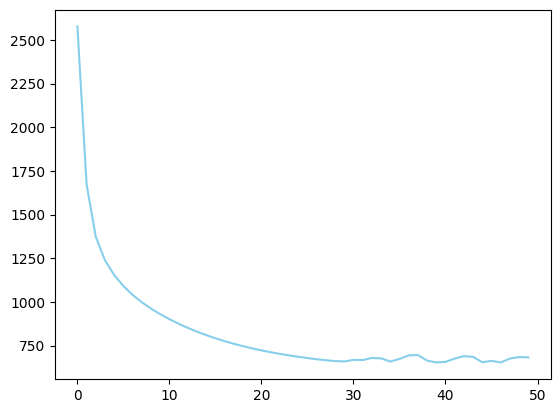

In [20]:
n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [27]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_all_layer=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word) # print the probability of words desc with the word "learning" as input

machine
algorithms
intelligence
so
the
are
build
is
learning
automatically
do
programmed
used
computer
to
artificial
sample
improve
applications
that
develop
conventional
without
training
perform
it
predictions
difficult
model
wide
subset
order
where
through
of
needed
study
a
known
explicitly
being
seen
data
infeasible
experience
mathematical
email
vision
tasks
variety
in
and
make
based
such
decisions
as
or
on
filtering


In [28]:
print(model["w1"][:3]) # the embedding of the first three words

array([[ 1.27606757, -0.23930799,  0.92850782, -0.27350692,  0.02606639,
        -0.51072715,  2.62462971, -0.75241704, -1.01879004,  0.81882112],
       [ 0.61147124, -1.42346717, -0.32171558, -1.07283129, -1.00561012,
        -2.49911471, -0.37771402,  0.86784345,  0.17782003, -0.58753951],
       [ 0.85330422,  0.43102562,  0.12112686, -2.4569169 , -1.06032876,
        -0.00930637, -0.9663769 ,  0.0683869 ,  0.39359238, -0.76727018]])

In [29]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [30]:
get_embedding(model, "machine")

array([-0.61291034,  1.28743709, -0.22047015,  0.12831734, -0.65204058,
       -0.77653976, -0.41152325,  0.31266731, -1.64929041, -0.81527973])